### Import libraries

In [1]:
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Load dataset

In [2]:
df = pd.read_csv("dataset/banking.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### Handle missing values

In [3]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Replace 'unknown' with the most frequent value (imputation)
for col in categorical_columns:
    if df[col].dtype == 'object':
        mode_val = df[col].mode()[0]
        df[col] = df[col].replace('unknown', mode_val)

#### Handle outliers

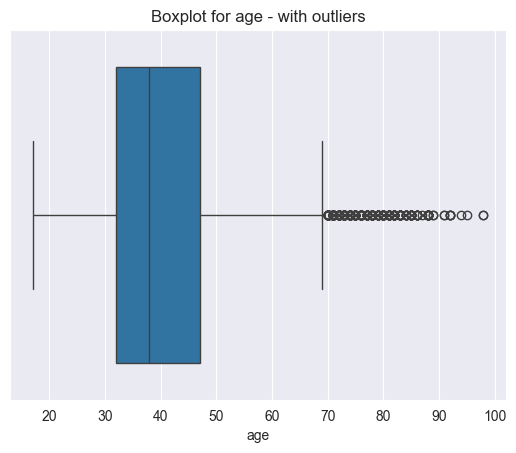

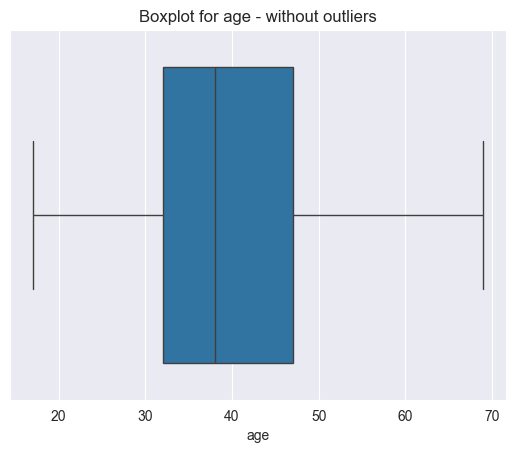

In [4]:
# Visualizing 'age' column using a boxplot with outliers
sns.boxplot(x=df['age'])
plt.title('Boxplot for age - with outliers')
plt.show()

# Remove outliers using IQR method
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

# Visualizing 'age' column using a boxplot without outliers
sns.boxplot(x=df_no_outliers['age'])
plt.title('Boxplot for age - without outliers')
plt.show()

### Suitable feature coding techniques

In [5]:
# Store label encoders for each categorical columns
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

### Standardization & Scaling

In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['y']))
df_scaled_df = pd.DataFrame(df_scaled, columns=df.drop(columns=['y']).columns)

### Split dataset

In [7]:
# Split features and target
X = df.drop(columns=["y"])
y = df["y"]

# Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train SVM Model (Support Vector Machine)

In [8]:
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

### Train LR Model (Logistic Regression)

In [9]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Save models

In [10]:
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(label_encoders, "models/encoder.pkl")
joblib.dump(svm_model, "models/svm_model.pkl")
joblib.dump(lr_model, "models/lr_model.pkl")
print("Models saved successfully!")

Models saved successfully!


### Test models

In [11]:
# New data
new_data = pd.DataFrame({
    'age': [44, 53, 28, 39, 55],
    'job': ['blue-collar', 'technician', 'management', 'services', 'retired'],
    'marital': ['married', 'married', 'single', 'married', 'married'],
    'education': ['basic.4y', 'unknown', 'university.degree', 'high.school', 'basic.4y'],
    'default': ['unknown', 'no', 'no', 'no', 'no'],
    'housing': ['yes', 'no', 'yes', 'no', 'yes'],
    'loan': ['no', 'no', 'no', 'no', 'no'],
    'contact': ['cellular', 'cellular', 'cellular', 'cellular', 'cellular'],
    'month': ['aug', 'nov', 'jun', 'apr', 'aug'],
    'day_of_week': ['thu', 'fri', 'thu', 'fri', 'fri'],
    'duration': [210, 138, 339, 185, 137],
    'campaign': [1, 1, 3, 2, 1],
    'pdays': [999, 999, 6, 999, 3],
    'previous': [0, 0, 2, 0, 1],
    'poutcome': ['nonexistent', 'nonexistent', 'success', 'nonexistent', 'success'],
    'emp_var_rate': [1.4, -0.1, -1.7, -1.8, -2.9],
    'cons_price_idx': [93.444, 93.2, 94.055, 93.075, 92.201],
    'cons_conf_idx': [-36.1, -42, -39.8, -47.1, -31.4],
    'euribor3m': [4.963, 4.021, 0.729, 1.405, 0.869],
    'nr_employed': [5228.1, 5195.8, 4991.6, 5099.1, 5076.2],
})

# Apply feature encoding
for column in new_data.columns:
    if column in label_encoders:
        mode_val = new_data[column].mode()[0]
        new_data[column] = new_data[column].replace('unknown', mode_val)
        new_data[column] = label_encoders[column].transform(new_data[column])

# Scale the new data
new_data_scaled = scaler.transform(new_data)

# Convert the scaled
new_data_scaled_df = pd.DataFrame(new_data_scaled, columns=X.columns)

### Using SVM

In [12]:
y_pred_svm = svm_model.predict(new_data_scaled_df.values)
for i, pred in enumerate(y_pred_svm):
    if pred == 1:
        print(f"Subscribe to a term deposit: Yes")
    else:
        print(f"Subscribe to a term deposit: No")

Subscribe to a term deposit: No
Subscribe to a term deposit: No
Subscribe to a term deposit: Yes
Subscribe to a term deposit: No
Subscribe to a term deposit: No


### Using LR

In [13]:
y_pred_lr = lr_model.predict(new_data_scaled_df.values)
for i, pred in enumerate(y_pred_lr):
    if pred == 1:
        print(f"Subscribe to a term deposit: Yes")
    else:
        print(f"Subscribe to a term deposit: No")

Subscribe to a term deposit: No
Subscribe to a term deposit: No
Subscribe to a term deposit: Yes
Subscribe to a term deposit: No
Subscribe to a term deposit: No
